In [2]:
# data handling
import numpy as np
import pandas as pd

# graphics
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

print('Libraries imported correctly')

Libraries imported correctly


## Import datasets

In [3]:
data_folder = '../data'

# Read train
print('Reading training set')
train = pd.read_csv(f'{data_folder}/train.csv')
print(f'Number of rows for the train set is: {train.shape[0]}')
print(f'Number of columns for the train set is: {train.shape[1]}\n')

# Read train_labels
print('Reading train_labels')
train_labels = pd.read_csv(f'{data_folder}/train_labels.csv')
print(f'Number of rows for the train_labels is: {train_labels.shape[0]}')
print(f'Number of columns for the train_labels is: {train_labels.shape[1]}\n')

# Read test
print('Reading test set')
test = pd.read_csv(f'{data_folder}/test.csv')
print(f'Number of rows for the test set is: {test.shape[0]}')
print(f'Number of columns for the test set is: {test.shape[1]}\n')

Reading training set
Number of rows for the train set is: 11341042
Number of columns for the train set is: 11

Reading train_labels
Number of rows for the train_labels is: 17690
Number of columns for the train_labels is: 7

Reading test set
Number of rows for the train set is: 1156414
Number of columns for the train set is: 11



Lets see the variables and explain each one

In [4]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


**event_id**: Event identifier

**game_session**: identifier of the game session (playing session as in "one sitting"), installation_id has 1:n game sessions

**timestamp**: timestamp of the event

**event_data**: specific data regarding the activity type and title. This columns is interesting to dig in but for now some of the interesting values are:
* 2000: stands for initiating game/activity
* 4100: assesment try, when this code is pressent "correct" is also present, meaning that if true the assessment has been resolvel gracefully, otherwise is false
* 4110: same as 4100 but specific for the bird game

**installation_id**: identifier of game installation in a device, ie: game installed in an iPad, this is it's id

**event_count**: accumulative count of the number of events in an activity, ie: playing a title has the start of the game event (2000) plus all the events generated by the kid (moving pieces for example) plus an assement try.

**event_code**: action code of the event in the observation, as exposed in event_data each code corresponds to a certain action

**game_time**: overall time of the activity between events in miliseconds

**title**: title of the game, it can be from a clip, activity, assessment or game

**type**: Clip, Activity, Game or Assessment, the last one is the one we should be predicting the accuracy group for the test set

**world**: worlds inside the game, "NONE" is the starting screen

### Tasks:

* Distributions, NAs, uniques
* timestamp: when does the dataset starts, when does it ends, hits per unit (ie: day)
* event_data: analyze codes, and the different key values contained depending on code
* installation_id: mean game sessions, events, activities
* game_time: average gametime between sessions, sum of time in a whole session
* event_code: retrieve action per code


## Analysis of event_id

In [6]:
print(f'Number of unique values in train {train.event_id.nunique()}')
print(f'Number of unique values in test {test.event_id.nunique()}')

Number of unique values in train 384
Number of unique values in test 365


In [10]:
disjoint_event_ids = list(set(train.event_id.drop_duplicates()).difference(set(test.event_id.drop_duplicates())))
print(disjoint_event_ids)

['29a42aea', '119b5b02', '13f56524', '0ce40006', 'bfc77bd6', 'ecc6157f', '611485c5', 'a8cc6fec', '7fd1ac25', '17ca3959', '1b54d27f', 'ab4ec3a4', '2ec694de', '01ca3a3c', '4074bac2', '003cd2ee', '5dc079d8', 'dcb1663e', 'e4d32835']


There seems to be some events_id that are train set but not in test set, lets check out one of them 

In [17]:
train[train.event_id == '29a42aea']

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
314929,29a42aea,fc7d0ebdcec03dc6,2019-10-04T17:42:46.872Z,"{""dwell_time"":25220,""object"":""cabinet"",""round""...",063e3e02,254,4080,370859,Bubble Bath,Game,MAGMAPEAK
315050,29a42aea,4a26abfbf30186c2,2019-10-09T01:10:28.687Z,"{""dwell_time"":1882,""object"":""window"",""round"":1...",063e3e02,76,4080,114842,Bubble Bath,Game,MAGMAPEAK
1810730,29a42aea,243781973cbcaa65,2019-07-30T01:16:37.242Z,"{""dwell_time"":2122,""object"":""cabinet"",""round"":...",29d1aaee,83,4080,91707,Bubble Bath,Game,MAGMAPEAK
3036086,29a42aea,6de5e45bec988ffb,2019-08-23T16:30:25.717Z,"{""dwell_time"":2018,""object"":""cabinet"",""round"":...",433726dc,347,4080,232471,Bubble Bath,Game,MAGMAPEAK
5195281,29a42aea,6cb9f3e623223309,2019-09-19T12:29:46.604Z,"{""dwell_time"":13460,""object"":""cabinet"",""round""...",73a5310e,53,4080,86070,Bubble Bath,Game,MAGMAPEAK
6093455,29a42aea,2166d754fdcc9b37,2019-08-20T20:03:25.901Z,"{""dwell_time"":2148,""object"":""window"",""round"":1...",86c58053,38,4080,89954,Bubble Bath,Game,MAGMAPEAK
6294665,29a42aea,6e929a0c84029dcc,2019-09-13T13:02:14.173Z,"{""dwell_time"":3351,""object"":""cabinet"",""round"":...",8b420df0,113,4080,197482,Bubble Bath,Game,MAGMAPEAK
6911299,29a42aea,2c62388b8f094da6,2019-09-07T22:36:00.471Z,"{""dwell_time"":1398,""object"":""towel"",""round"":3,...",9a6ffb62,157,4080,204596,Bubble Bath,Game,MAGMAPEAK
6911301,29a42aea,2c62388b8f094da6,2019-09-07T22:36:01.559Z,"{""dwell_time"":1090,""object"":""cabinet"",""round"":...",9a6ffb62,159,4080,205686,Bubble Bath,Game,MAGMAPEAK
7827546,29a42aea,2adcc8a38feb4b62,2019-07-26T15:47:16.032Z,"{""dwell_time"":11126,""object"":""ship"",""round"":3,...",af6786f7,313,4080,344758,Bubble Bath,Game,MAGMAPEAK


This event_id seems to be related to the 4080 code (236 out of 241) and 2010, but there are observations with different event id but same code, lets checkout the different titles and games for those event_code's

In [44]:
train[train.event_id.isin(disjoint_event_ids)].event_code.value_counts()

4080    236
2010      5
Name: event_code, dtype: int64

In [58]:
# Check the different titles with thath event id and without
titles_in_disjoint = train[train.event_id.isin(disjoint_event_ids)].title.value_counts().index
print(f'Length of titles in disjoint event_id\'s: {len(titles_in_disjoint)}')
titles_off_disjoint = train[((train.event_code == 4080) | (train.event_code == 2010)) & (~train.event_id.isin(disjoint_event_ids))].title.value_counts().index
print(f'Length of titles off disjoint event_id\'s: {len(titles_off_disjoint)}')
diff_in_titles = list(set(titles_in_disjoint).difference(set(titles_off_disjoint)))
print(diff_in_titles)

# Check the titles in the test set with 4080 and 2010 codes
titles_off_disjoint_test = train[((train.event_code == 4080) | (train.event_code == 2010)) & (~train.event_id.isin(disjoint_event_ids))].title.value_counts().index
print(f'Length of titles off disjoint event_id\'s: {len(titles_off_disjoint)}')

print(list(titles_off_disjoint_test))

print(f'Common titles in train and test: {list(set(diff_in_titles).intersection(set(titles_off_disjoint_test)))}')

Length of titles in disjoint event_id's: 18
Length of titles off disjoint event_id's: 11
['Fireworks (Activity)', 'Happy Camel', 'Egg Dropper (Activity)', 'Air Show', 'Bug Measurer (Activity)', 'Dino Drink', 'Crystals Rule', 'Leaf Leader', 'Dino Dive', 'Scrub-A-Dub', 'Pan Balance', 'Bubble Bath', 'Watering Hole (Activity)']
Length of titles off disjoint event_id's: 11
['Cart Balancer (Assessment)', 'Mushroom Sorter (Assessment)', 'Cauldron Filler (Assessment)', 'Bird Measurer (Assessment)', 'Chest Sorter (Assessment)', 'Chow Time', 'Bottle Filler (Activity)', 'Chicken Balancer (Activity)', 'All Star Sorting', 'Sandcastle Builder (Activity)', 'Flower Waterer (Activity)']
Common titles in train and test: []


It seems that some titles that are have an event_id that is not in the test set might come from different games, once qe start with the modeling, **getting rid of the observation with those events** can be a test of FE.  

## Analysis of game_session

In [63]:
print(f'Sum of unique values for game_session: {train.game_session.nunique()}')
print(f'Average hits for game_session: {train.game_session.value_counts().values.mean()}')

Sum of unique values for game_session: 303319
Average hits for game_session: 37.389817321038244


Let's see the distribution of hits for both train and test

/home/gnm/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


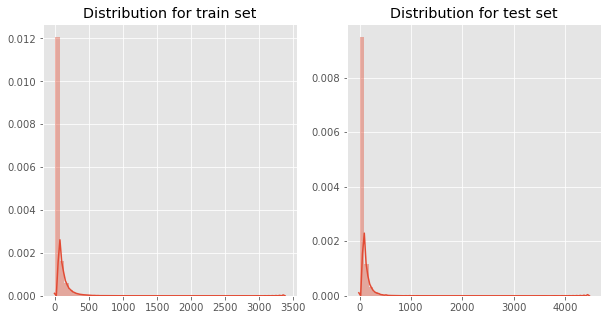

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Distribution for train set')
ax[1].set_title('Distribution for test set')

sns.distplot(train.game_session.value_counts().values, ax=ax[0],)
sns.distplot(test.game_session.value_counts().values, ax=ax[1])

Seems like most kids do not engage in long game sessions and the distribution matches train and test.

Lets check out the average game time of all the sessions

In [103]:
sessions_total_time = np.zeros(train.game_session.nunique())
for i, sess in enumerate(train[['game_session', 'game_time']].groupby('game_session', sort=False)):
    sessions_total_time[i] = sess[1].iloc[-1, -1]
sess_time = pd.DataFrame(sessions_total_time, columns='duration')

/home/gnm/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


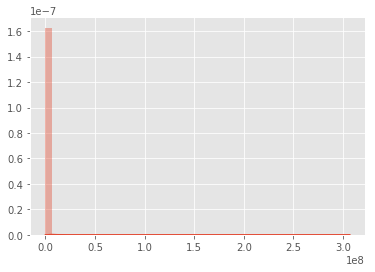

In [104]:
sns.distplot(sess_time)

Seems thath most game sessions durations is about zero, lets see hoy many of them are zero and the average game duration


In [119]:
sess_time.duration.value_counts().iloc[:10]

0.0      186361
390.0        22
391.0        18
395.0        18
392.0        18
394.0        17
387.0        16
396.0        15
399.0        15
66.0         14
Name: duration, dtype: int64

In [124]:
print(f'Average seconds for each game_session {float(sess_time.mean()/1000)}')

Average seconds for each game_session 83.45795093614313


Zero durations makes for more than a half of the game sessions, maybe when the game starts it generates onse gaming session and after a world is selected another one starts, alo its seems that can depend on the title that is actually playing, so a game session might be de duration of a specific activity

*FE*: identify the sessions and unify them in one

## Analysis of timestamp

In [128]:
train['timestamp'] = train.timestamp.apply(lambda x: pd.Timestamp(x))

In [ ]:
train['hour'] = train.timestamp.apply(lambda x: x.hour)
train['date'] = train.timestamp.apply(lambda x: x.date)
train.head()

In [59]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK
